# Intro

X -> Y makes supervised machine learning. We tried with random numbers. We tried with images. Pixels are numbers. Everything is numbers.

We can treat text the same way.

In [1]:
from datasets import load_dataset
from collections import Counter
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pickle
import json
from pathlib import Path
import torch 
import torch.nn as nn

/Users/priyansh.trivedi/Dev/learning/dl-workinggroup/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the dataset
imdb = load_dataset("imdb")

len(imdb['train']), imdb['train'][0]

Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /Users/priyansh.trivedi/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Nov 18 16:14:25 2024).


(25000,
 {'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few a

# One Hot Vectors

![One Hot](https://miro.medium.com/max/828/1*9ZuDXoc2ek-GfHE2esty5A.webp)
src - https://medium.com/intelligentmachines/word-embedding-and-one-hot-encoding-ad17b4bbe111

In [3]:
document = "Rome Paris Italy France Potato Kartoffeln Patate".lower()
tokens = document.split(' ')

tokens

['rome', 'paris', 'italy', 'france', 'potato', 'kartoffeln', 'patate']

In [4]:
vocab = {}
for token in tokens:
    token = token.lower()
    if not token in vocab:
        vocab[token] = len(vocab)
        
vocab

{'rome': 0,
 'paris': 1,
 'italy': 2,
 'france': 3,
 'potato': 4,
 'kartoffeln': 5,
 'patate': 6}

In [5]:
vocab = {}
for token in tokens:
    vocab.setdefault(token, len(vocab))
        
vocab

{'rome': 0,
 'paris': 1,
 'italy': 2,
 'france': 3,
 'potato': 4,
 'kartoffeln': 5,
 'patate': 6}

In [6]:
one_hots = []
one_hots = np.zeros((len(vocab), len(tokens)))
for word_nr, token in enumerate(tokens):
    word_id = vocab[token]
    one_hots[word_id, word_nr] = 1
    
one_hots

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

# Multi-Hot Bag of Words

### IMDB

In [7]:
# Lets just work with 1000 documents for now

train_text = [instance['text'] for instance in imdb['train']]#[:1000]
train_labels = [instance['label'] for instance in imdb['train']]#[:1000]

# Preprocess (estimate: 30-40 minutes).

This is the most difficult part ^^

## 1. Tokenize Text

Document is one long string of text -> One unit (pixel) can be a word.

In [8]:
def tokenize(document):
    document = document.replace(".", " .").replace("!", " !")
    return document.split()

In [9]:
# Test our basic tokenizer
'|'.join(tokenize(imdb['train'][0]['text']))

'I|rented|I|AM|CURIOUS-YELLOW|from|my|video|store|because|of|all|the|controversy|that|surrounded|it|when|it|was|first|released|in|1967|.|I|also|heard|that|at|first|it|was|seized|by|U|.S|.|customs|if|it|ever|tried|to|enter|this|country,|therefore|being|a|fan|of|films|considered|"controversial"|I|really|had|to|see|this|for|myself|.<br|/><br|/>The|plot|is|centered|around|a|young|Swedish|drama|student|named|Lena|who|wants|to|learn|everything|she|can|about|life|.|In|particular|she|wants|to|focus|her|attentions|to|making|some|sort|of|documentary|on|what|the|average|Swede|thought|about|certain|political|issues|such|as|the|Vietnam|War|and|race|issues|in|the|United|States|.|In|between|asking|politicians|and|ordinary|denizens|of|Stockholm|about|their|opinions|on|politics,|she|has|sex|with|her|drama|teacher,|classmates,|and|married|men|.<br|/><br|/>What|kills|me|about|I|AM|CURIOUS-YELLOW|is|that|40|years|ago,|this|was|considered|pornographic|.|Really,|the|sex|and|nudity|scenes|are|few|and|far|bet

### Spacy Tokenizer
This one is actually useful.

### To Install It

`! pip install spacy`

`! python -m spacy download en_core_web_sm`

within jupyter cells (if you're not using uv)

In [10]:
# Actually useful tokenizer
import spacy
exclude = ["parser", "tagger", "ner", "textcat", "attribute_ruler", "lemmatizer"]
nlp = spacy.load("en_core_web_sm", exclude=exclude)

def get_spacy_tokens(text):
    return [token.text for token in nlp(text)]

In [11]:
# Test Spacy Tokenizer
tokens = get_spacy_tokens(train_text[0])
'|'.join(tokens)

'I|rented|I|AM|CURIOUS|-|YELLOW|from|my|video|store|because|of|all|the|controversy|that|surrounded|it|when|it|was|first|released|in|1967|.|I|also|heard|that|at|first|it|was|seized|by|U.S.|customs|if|it|ever|tried|to|enter|this|country|,|therefore|being|a|fan|of|films|considered|"|controversial|"|I|really|had|to|see|this|for|myself.<br|/><br|/>The|plot|is|centered|around|a|young|Swedish|drama|student|named|Lena|who|wants|to|learn|everything|she|can|about|life|.|In|particular|she|wants|to|focus|her|attentions|to|making|some|sort|of|documentary|on|what|the|average|Swede|thought|about|certain|political|issues|such|as|the|Vietnam|War|and|race|issues|in|the|United|States|.|In|between|asking|politicians|and|ordinary|denizens|of|Stockholm|about|their|opinions|on|politics|,|she|has|sex|with|her|drama|teacher|,|classmates|,|and|married|men.<br|/><br|/>What|kills|me|about|I|AM|CURIOUS|-|YELLOW|is|that|40|years|ago|,|this|was|considered|pornographic|.|Really|,|the|sex|and|nudity|scenes|are|few|and

In [12]:
# # Tokenize Everything 
# # NOTE: this might take some time. There are ways to speed it up but we dont need that for now
# tokenized_train_text = []
# for text in tqdm(train_text):
#    tokenized_train_text.append(get_spacy_tokens(text))

In [13]:
# # This takes 2-5 minutes. We'll talk till then ^^'
# train_docs = list(nlp.pipe(train_text))
# tokenized_train_text = [[tok.text for tok in doc] for doc in train_docs]

# This is faster:
# Process documents in batches to save memory
tokenized_train_text = []
for doc_batch in nlp.pipe(train_text, batch_size=200, n_process=-1, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    tokenized_train_text.append([token.text for token in doc_batch])

print(f"Tokenized {len(tokenized_train_text)} documents")

Tokenized 25000 documents


## 1.1 Exploring the data 

- Length Distribution


Over 25000 documents, the mean is 272.46 ± 202.59


[]

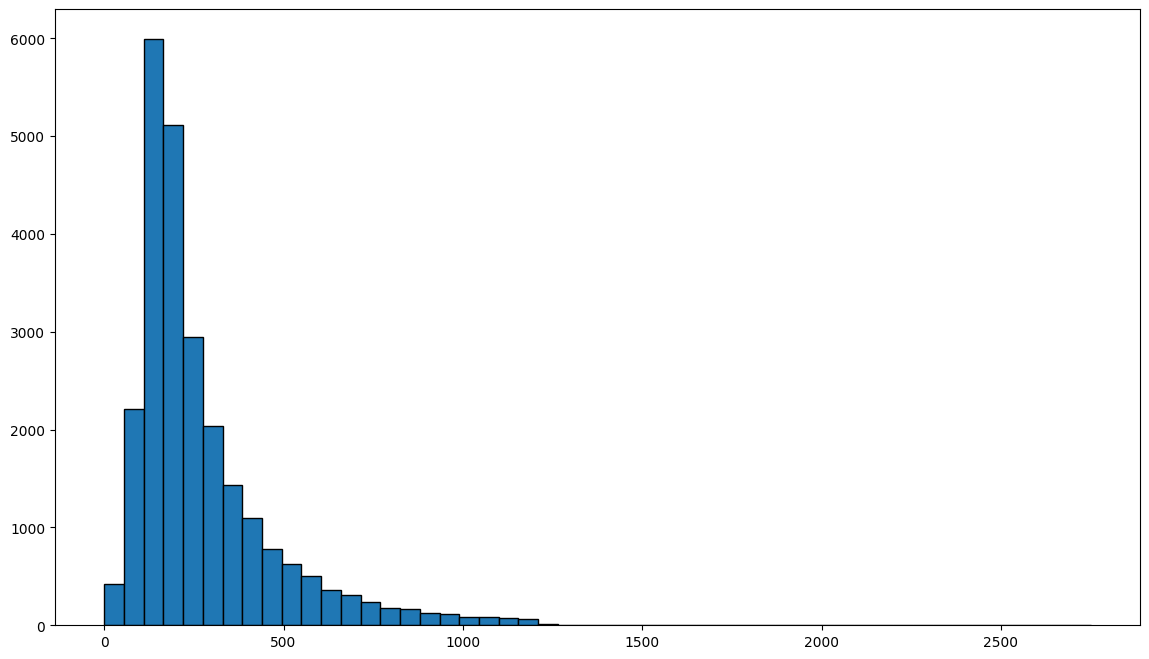

In [14]:
lens = [len(doc) for doc in tokenized_train_text]
bin_ranges = [i for i in range(0, max(lens), max(lens)//50)]

#create histogram with 4 bins
print(f"Over {len(lens)} documents, the mean is {np.mean(lens):.2f} ± {np.std(lens):.2f}")
plt.figure(figsize=(14, 8))
plt.hist(lens, bins=bin_ranges, edgecolor='black')
plt.plot()

In [15]:
# # Lets decide on a maximum length of documents based on this. Say 200
# maxlen = 200

## 2. Create Vocabulary

In [16]:
# The same setdefault stuff we did above
vocab = {}
for document in tqdm(tokenized_train_text):
    for token in document:
        vocab.setdefault(token, len(vocab))
    
len(vocab)

100%|██████████| 25000/25000 [00:00<00:00, 41412.32it/s]


121065

### That's way too many words. 121065?

Let's make sure we have only 10000 words. 

First 10000 words?


NO! The most common 10000 words

How?
- count the frequency of all the tokens
- sort it and choose top 10,000
- turn text to IDs based on this. For the rejected words, turn them into something like 'UNKNOWN'.

In [17]:
# Understanding Counters
counter = Counter()

counter.update(['the', 'red', 'pill'])
print(counter)
counter.update(['the', 'blue', 'gill'])
print(counter)

Counter({'the': 1, 'red': 1, 'pill': 1})
Counter({'the': 2, 'red': 1, 'pill': 1, 'blue': 1, 'gill': 1})


In [18]:
counter = Counter()
for document in tqdm(tokenized_train_text):
    counter.update(document)

100%|██████████| 25000/25000 [00:00<00:00, 56957.34it/s]


In [19]:
len(counter), counter.most_common(10)

(121065,
 [('the', 289838),
  (',', 275296),
  ('.', 236709),
  ('and', 156484),
  ('a', 156282),
  ('of', 144056),
  ('to', 133886),
  ('is', 109095),
  ('in', 87676),
  ('I', 77546)])

Vocabulary size: 121065 unique words
Most common word appears 289838 times
Mean word frequency: 56.26 ± 1813.84


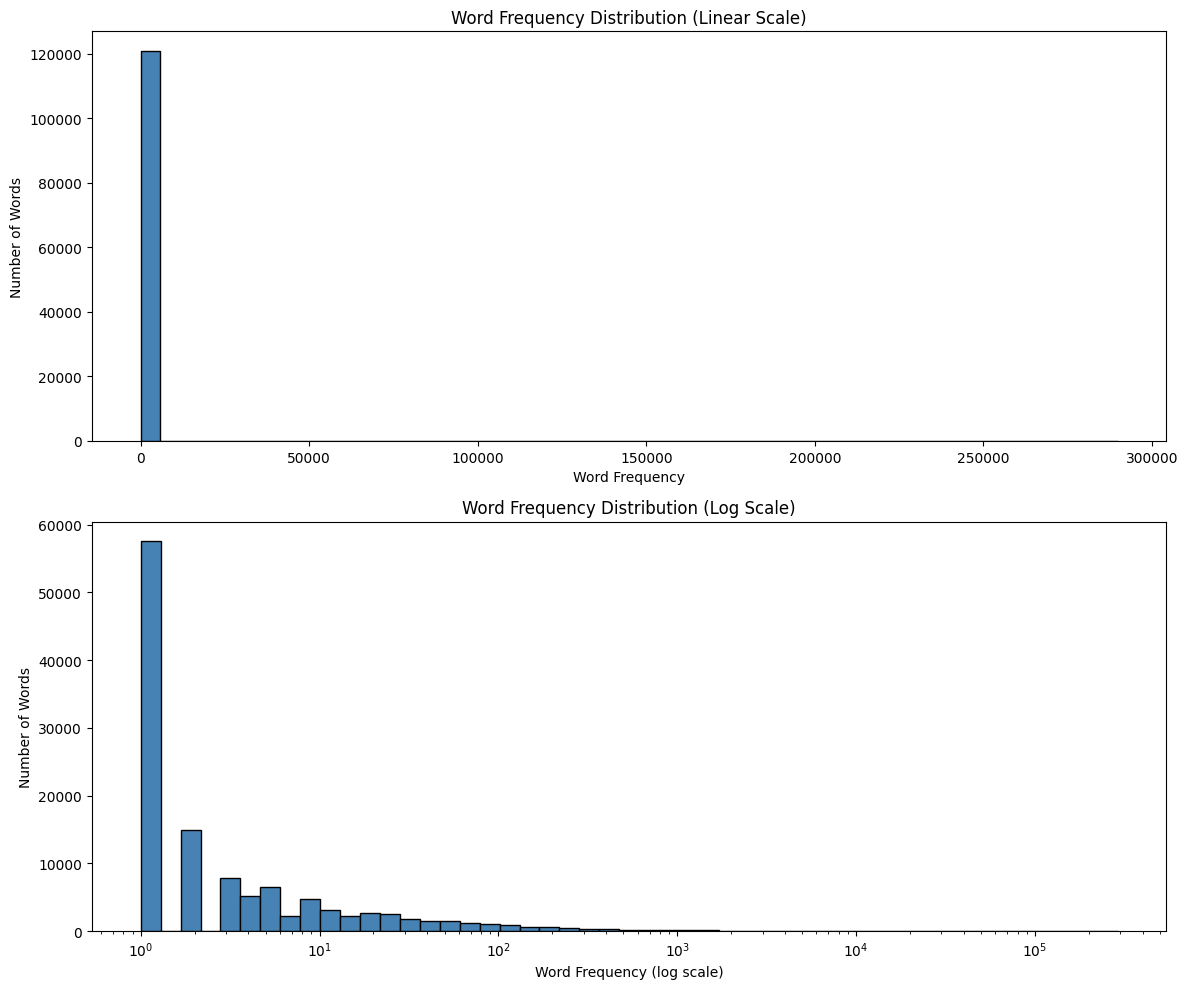

In [20]:
# Plot the word frequencies to help decide on a vocabulary limit
word_counts = [count for word, count in counter.most_common()]
total_words = len(word_counts)

# Create a more informative print statement
print(f"Vocabulary size: {total_words} unique words")
print(f"Most common word appears {word_counts[0]} times")
print(f"Mean word frequency: {np.mean(word_counts):.2f} ± {np.std(word_counts):.2f}")

# Create a cleaner plotting setup
plt.figure(figsize=(12, 10))

# Plot frequency distribution on log scale (more informative for power law distributions)
plt.subplot(211)
plt.hist(word_counts, bins=50, color='steelblue', edgecolor='black')
plt.title('Word Frequency Distribution (Linear Scale)')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')

# Plot on log scale to better visualize the long tail
plt.subplot(212)
plt.hist(word_counts, bins=np.logspace(0, np.log10(max(word_counts)), 50), 
         color='steelblue', edgecolor='black')
plt.xscale('log')
plt.title('Word Frequency Distribution (Log Scale)')
plt.xlabel('Word Frequency (log scale)')
plt.ylabel('Number of Words')

plt.tight_layout()
plt.show()

In [21]:
n_words = 10000

In [22]:
# Lets create the actual vocab now. 
# We need one special word for 'UNKNOWN': those words that our 'out of vocabulary' for us
# and for 'PADDING': when a sequence is less than the seuqence length we decided
vocab = {'--UNK--': 0, '--PAD--': 1} 

for i, (k,v) in enumerate(counter.most_common(n_words)):
    vocab.setdefault(k, len(vocab))

In [23]:
n_words = n_words + 2 # for special characters

!! **Good idea to go through the vocabulary, spot the fishy ones and re-adapt your preprocessing to take care of them.**


## 3. Coverting tokens to word IDs


In [24]:
wordid_train_text = [[vocab.get(tok, vocab['--UNK--']) for tok in doc] for doc in tokenized_train_text]
# bow_train_text = [list(set(doc)) for doc in wordid_train_text]

In [25]:
! free -h

zsh:1: command not found: free


### 3.2 Do the same for test text


In [26]:
test_text = [instance['text'] for instance in imdb['test']]#[:1000]
test_labels = [instance['label'] for instance in imdb['test']]#[:1000]
test_docs = list(nlp.pipe(test_text, batch_size=200, n_process=-1, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]))
tokenized_test_text = [[tok.text for tok in doc] for doc in test_docs]
wordid_test_text = [[vocab.get(tok, vocab['--UNK--']) for tok in doc] for doc in tokenized_test_text]


## 4. Dump this stuff to disk

Next step is a transformation where we lose information (i.e. cant get sequence back from Bag of Words)

In [ ]:
# Dump the WordID and vocab to disk
dump_dir = Path('../resources/datasets/imdb/proc')
dump_dir.mkdir(parents=True, exist_ok=True)
with (dump_dir/'vocab.json').open('w+') as f:
    json.dump(vocab, f)
    
with (dump_dir/'wordids_train.pkl').open('wb+') as f:
    pickle.dump(wordid_train_text, f)
    
with (dump_dir/'train_labels.pkl').open('wb+') as f:
    pickle.dump(train_labels, f)
    
with (dump_dir/'wordids_test.pkl').open('wb+') as f:
    pickle.dump(wordid_test_text, f)
    
with (dump_dir/'test_labels.pkl').open('wb+') as f:
    pickle.dump(test_labels, f)

In [ ]:
# Try loading from disk
dump_dir = Path('../resources/datasets/imdb/proc')
with (dump_dir/'vocab.json').open('r') as f:
    vocab = json.load(f)
    
with (dump_dir/'wordids_train.pkl').open('rb') as f:
    wordid_train_text = pickle.load(f)
    
with (dump_dir/'train_labels.pkl').open('rb') as f:
    train_labels = pickle.load(f)
    
with (dump_dir/'wordids_test.pkl').open('rb') as f:
    wordid_test_text = pickle.load(f)
    
with (dump_dir/'test_labels.pkl').open('rb') as f:
    test_labels = pickle.load(f)
    
n_words = len(vocab)

In [29]:
wordid_train_text[0]

[11,
 1653,
 11,
 0,
 0,
 17,
 0,
 46,
 83,
 419,
 1163,
 101,
 7,
 42,
 2,
 7849,
 13,
 3554,
 12,
 70,
 12,
 19,
 106,
 668,
 10,
 7616,
 4,
 11,
 108,
 587,
 13,
 41,
 106,
 12,
 19,
 0,
 40,
 2451,
 0,
 76,
 12,
 145,
 820,
 8,
 3683,
 16,
 754,
 3,
 2134,
 128,
 6,
 360,
 7,
 123,
 1206,
 14,
 3226,
 14,
 11,
 77,
 73,
 8,
 80,
 16,
 23,
 0,
 18,
 118,
 129,
 9,
 4313,
 208,
 6,
 219,
 4384,
 490,
 1534,
 795,
 4963,
 44,
 511,
 8,
 873,
 346,
 72,
 69,
 51,
 134,
 4,
 159,
 862,
 72,
 511,
 8,
 1154,
 49,
 0,
 8,
 256,
 59,
 460,
 7,
 691,
 28,
 65,
 2,
 902,
 0,
 214,
 51,
 845,
 1003,
 1380,
 161,
 20,
 2,
 2692,
 982,
 5,
 1673,
 1380,
 10,
 2,
 2635,
 2636,
 4,
 159,
 216,
 2283,
 8351,
 5,
 2066,
 0,
 7,
 0,
 51,
 79,
 5139,
 28,
 2588,
 3,
 72,
 52,
 420,
 21,
 49,
 490,
 1784,
 3,
 9080,
 3,
 5,
 1078,
 0,
 18,
 1123,
 1147,
 84,
 51,
 11,
 0,
 0,
 17,
 0,
 9,
 13,
 1528,
 177,
 635,
 3,
 16,
 19,
 1206,
 8631,
 4,
 2343,
 3,
 2,
 420,
 5,
 1068,
 158,
 32,
 186,
 5,
 257,

## 5. Bag of Words

We don't need sequences. 

In [30]:
# Case 1: Only one-hot representation

In [31]:
X = np.zeros((len(wordid_train_text), n_words), dtype=np.float32)
Y = np.asarray(train_labels, dtype=np.float32).reshape(-1, 1)

for i, wordid_document in enumerate(wordid_train_text):
    for token_id in wordid_document:
        X[i][token_id] = 1
    
    
X.max(), X.mean()

(np.float32(1.0), np.float32(0.013864007))

In [32]:
# Dump this to disk
dump_dir = dump_dir.parent / 'bow_onehot'
dump_dir.mkdir(parents=True, exist_ok=True)
with (dump_dir / 'X_train.np').open('wb+') as f:
    np.save(f, X)
    
with (dump_dir / 'Y_train.np').open('wb+') as f:
    np.save(f, Y)

In [33]:
# Do the same for test stuff
# Overwriting variable names to conserve RAM
X = np.zeros((len(wordid_test_text), n_words), dtype=np.float32)
Y = np.asarray(test_labels, dtype=np.float32).reshape(-1, 1)

for i, wordid_document in enumerate(wordid_test_text):
    for token_id in wordid_document:
        X[i][token_id] = 1
    
    
X.max(), X.mean()

(np.float32(1.0), np.float32(0.013560552))

In [34]:
# Dump this to disk
dump_dir = dump_dir.parent / 'bow_onehot'
dump_dir.mkdir(parents=True, exist_ok=True)
with (dump_dir / 'X_test.np').open('wb+') as f:
    np.save(f, X)
    
with (dump_dir / 'Y_test.np').open('wb+') as f:
    np.save(f, Y)

In [35]:
# Case 2: MultiHot Representations (with frequencies)

In [36]:
X = np.zeros((len(wordid_train_text), n_words), dtype=np.float32)
Y = np.asarray(train_labels, dtype=np.float32).reshape(-1, 1)

for i, wordid_document in enumerate(wordid_train_text):
    for token_id in wordid_document:
        X[i][token_id] += 1
    
X.max(), X.mean()

(np.float32(454.0), np.float32(0.02724074))

In [37]:
# Dump this to disk
dump_dir = dump_dir.parent / 'bow_multihot'
dump_dir.mkdir(parents=True, exist_ok=True)
with (dump_dir / 'X_train.np').open('wb+') as f:
    np.save(f, X)
    
with (dump_dir / 'Y_train.np').open('wb+') as f:
    np.save(f, Y)

In [38]:
# Do the same for test stuff
# Overwriting variable names to conserve RAM
X = np.zeros((len(wordid_test_text), n_words), dtype=np.float32)
Y = np.asarray(test_labels, dtype=np.float32).reshape(-1, 1)

for i, wordid_document in enumerate(wordid_test_text):
    for token_id in wordid_document:
        X[i][token_id] += 1
    
    
X.max(), X.mean()

(np.float32(294.0), np.float32(0.02662701))

In [39]:
# Dump this to disk
dump_dir = dump_dir.parent / 'bow_multihot'
dump_dir.mkdir(parents=True, exist_ok=True)
with (dump_dir / 'X_test.np').open('wb+') as f:
    np.save(f, X)
    
with (dump_dir / 'Y_test.np').open('wb+') as f:
    np.save(f, Y)

In [43]:
! du -hs ../resources/datasets/imdb/*


1.9G	../resources/datasets/imdb/bow_multihot
1.9G	../resources/datasets/imdb/bow_onehot
 30M	../resources/datasets/imdb/wordid_vocab
